# Implementation of Simple Moving Average (SMA) Crossover Strategy
inspired and adapted from shreyas sarda

In [16]:
# import libraries
import datetime
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
plt.style.use('fivethirtyeight')

We use pandas_datareader library to import data from Yahoo Finance

In [10]:
import yfinance as yf
import datetime

# Input the data
stock = input('Stock name is: ')
num_days = int(input('Number of days the analysis needs to be done (Please enter an integer): '))

# Set start date of analysis
start_date = (datetime.datetime.now() - datetime.timedelta(days=num_days)).strftime("%Y-%m-%d")

# Download data using yfinance
df = yf.download(stock, start=start_date)

# Remove rows having np.NaN
df.dropna(how='any', inplace=True)

# Print the data
print(df)

Stock name is: PLTR
Number of days the analysis needs to be done (Please enter an integer): 1500


[*********************100%%**********************]  1 of 1 completed

                 Open   High        Low      Close  Adj Close     Volume
Date                                                                    
2020-09-30  10.000000  11.41   9.110000   9.500000   9.500000  338584400
2020-10-01   9.690000  10.10   9.230000   9.460000   9.460000  124297600
2020-10-02   9.060000   9.28   8.940000   9.200000   9.200000   55018300
2020-10-05   9.430000   9.49   8.920000   9.030000   9.030000   36316900
2020-10-06   9.040000  10.18   8.900000   9.900000   9.900000   90864000
...               ...    ...        ...        ...        ...        ...
2024-03-15  23.850000  24.10  23.420000  23.490000  23.490000   61270500
2024-03-18  23.770000  24.18  23.320000  24.000000  24.000000   44083000
2024-03-19  23.500000  23.83  22.920000  23.799999  23.799999   43247200
2024-03-20  23.770000  24.65  23.670000  24.570000  24.570000   40273800
2024-03-21  25.299999  25.33  24.440001  24.490000  24.490000   36970200

[874 rows x 6 columns]


We first visualise the close price history of our chosen stock, Palantir Technologies.

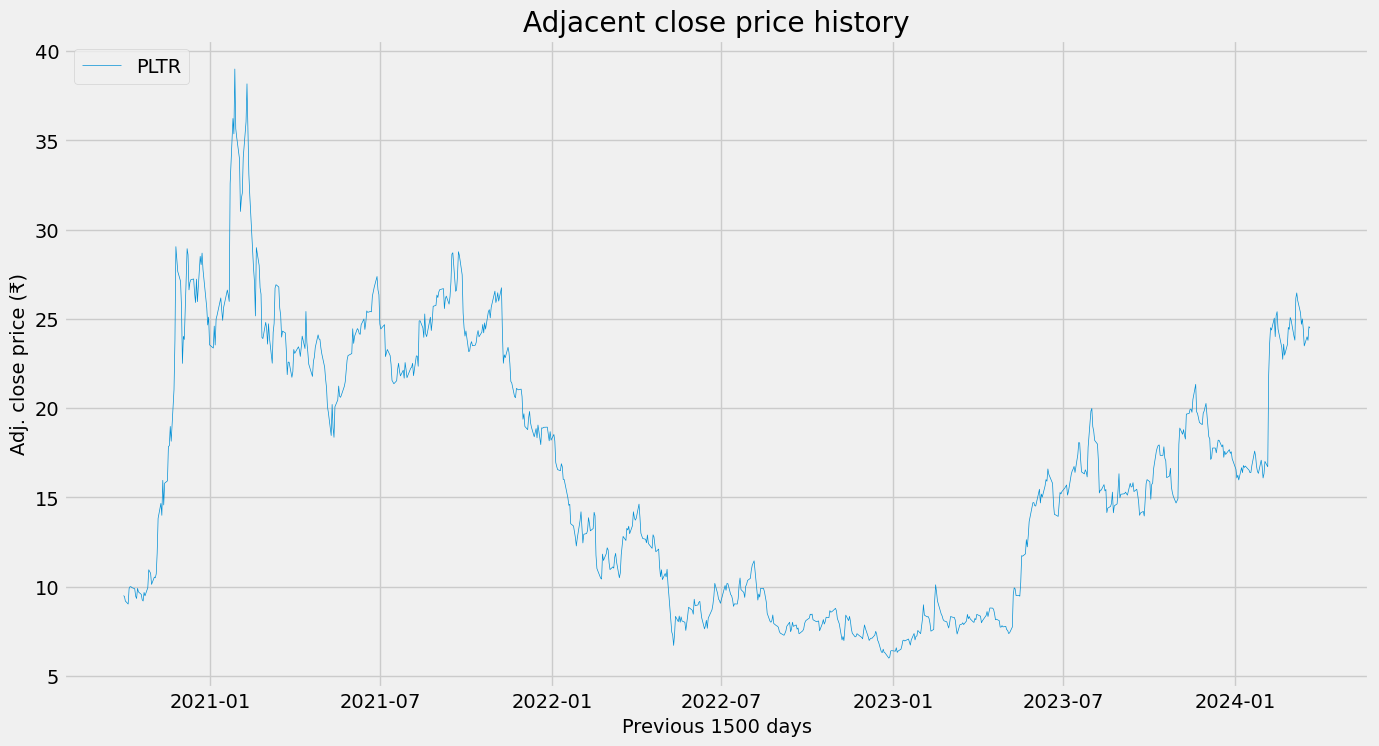

In [11]:
# Visualize data
plt.figure(figsize=(15, 8))
plt.plot(df['Adj Close'], label = stock, linewidth = 0.5)
plt.title('History of Adjacent close price')
plt.xlabel('Previous ' + str(num_days) + ' days')
plt.ylabel('Adj. close price (₹)')
plt.legend(loc = 'upper left')
plt.show()

In [12]:
# Create SMA Indicator
SMA20 = pd.DataFrame()
SMA20['Price'] = df['Adj Close'].rolling(window = 20).mean()
SMA50 = pd.DataFrame()
SMA50['Price'] = df['Adj Close'].rolling(window = 50).mean()

# Store all Data in new DataFrame
Data = pd.DataFrame()
Data['Price'] = df['Adj Close']
Data['SMA20'] = SMA20['Price']
Data['SMA50'] = SMA50['Price']
Data['funds'] = 100000         # Initialize funds so that it could be later modified

We then implement our strategy - SMA Crossover strategy, i.e. Buy a stock when its 20-Day SMA crosses 50-Day SMA from below and square off position when 20-Day SMA crosses 50-Day SMA from above.

In [13]:
# Create a function to signal when to buy and when to sell
def buy_sell_signal(data):
  buy_signal = []
  sell_signal = []
  open_position = []
  funds = [100000] * len(data)
  last_funds = 100000
  flag = 0  # flag = 0 means sell_flag and flag = 1 means buy_flag

  for i in range(len(data)):
    if data['SMA20'][i] > data['SMA50'][i]:
      if flag == 0:
        flag = 1
        buy_signal.append(data['Price'][i])
        last_pos = last_funds / data['Price'][i]
        funds[i] = last_funds
        open_position.append(last_pos)     # buy_quantity with 1 Lac Capital
        sell_signal.append(np.NaN)
      else:
        buy_signal.append(np.NaN)
        last_funds = data['Price'][i] * last_pos
        funds[i] = last_funds
        open_position.append(last_pos)
        sell_signal.append(np.NaN)
    elif data['SMA20'][i] < data['SMA50'][i]:
      if flag == 1:
        flag = 0
        buy_signal.append(np.NaN)
        last_funds = last_pos * data['Price'][i]
        funds[i] = last_funds
        open_position.append(0)
        sell_signal.append(data['Price'][i])
      else:
        buy_signal.append(np.NaN)
        funds[i] = last_funds
        open_position.append(0)
        sell_signal.append(np.NaN)
    else:
      buy_signal.append(np.NaN)
      open_position.append(0)
      sell_signal.append(np.NaN)
  return buy_signal, sell_signal, open_position, funds, flag

We then plot the SMA20 and SMA50 on the same graph as the PLTR stock price, and indicate the buy signal as a ^ and sell signal as a v. 

C:\Users\Goh Ming Wee\AppData\Local\Temp\ipykernel_1504\2113131358.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data['SMA20'][i] > data['SMA50'][i]:
C:\Users\Goh Ming Wee\AppData\Local\Temp\ipykernel_1504\2113131358.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif data['SMA20'][i] < data['SMA50'][i]:
C:\Users\Goh Ming Wee\AppData\Local\Temp\ipykernel_1504\2113131358.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

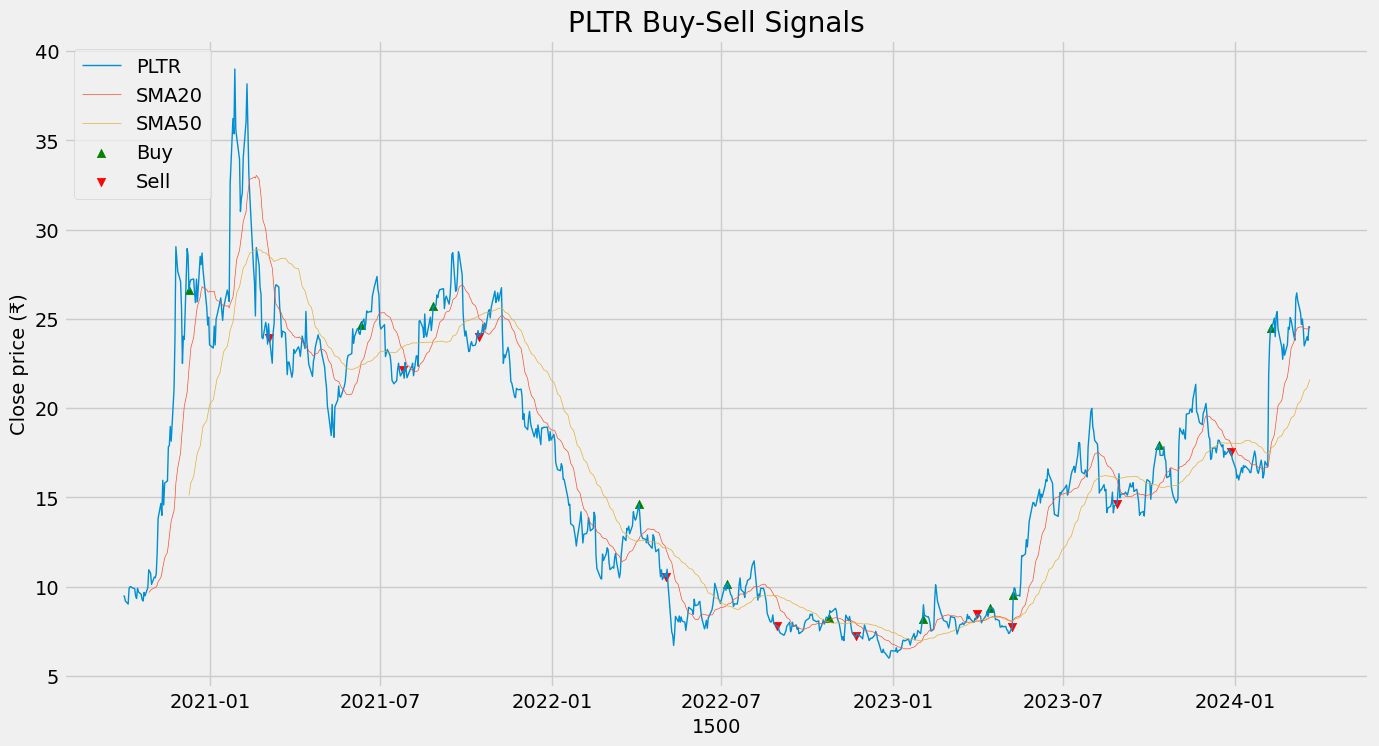

In [14]:
# Store buy and sell in Data
buy_sell = buy_sell_signal(Data)
#print(buy_sell)
Data['Buy_price'] = buy_sell[0]
Data['Sell_price'] = buy_sell[1]
Data['Open_pos'] = buy_sell[2]
Data['live_pos'] = Data['Open_pos'].multiply(Data['Price'])
Data['funds'] = buy_sell[3]

# Visualize Data and strategy to buy and sell NIFTY
plt.figure(figsize = (15, 8))
plt.plot(Data['Price'], label = str(stock), linewidth = 1)
plt.plot(Data['SMA20'], label = 'SMA20', linewidth = 0.5)
plt.plot(Data['SMA50'], label = 'SMA50', linewidth = 0.5)
plt.scatter(Data.index, Data['Buy_price'], label= 'Buy', marker = '^', color = 'g')
plt.scatter(Data.index, Data['Sell_price'], label= 'Sell', marker = 'v', color = 'r')
plt.title(str(stock) + ' Buy-Sell Signals')
plt.xlabel(num_days)
plt.ylabel('Close price (₹)')
plt.legend(loc = 'upper left')
plt.show()

We then plot and visualize the profit and loss of our strategy.

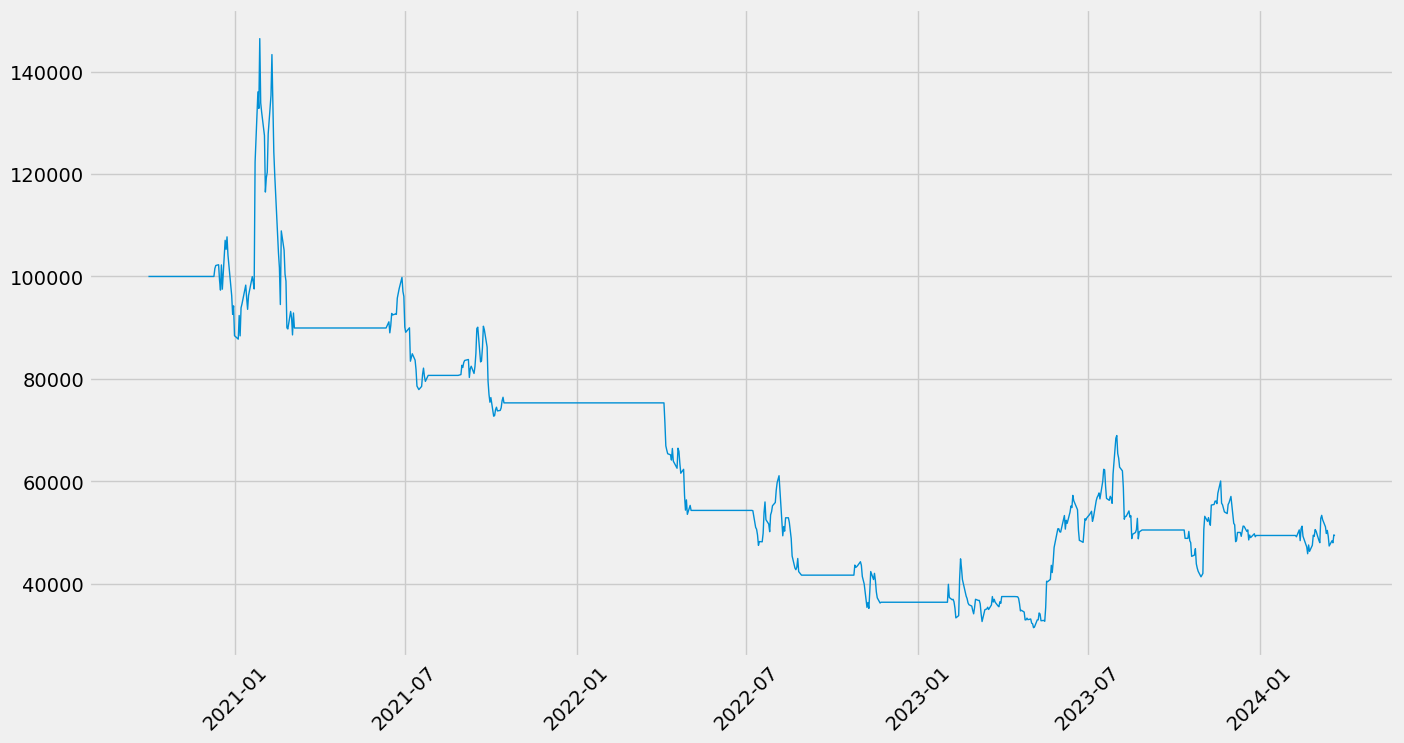

In [15]:
# Visualize results / PnL
plt.figure(figsize = (15, 8))
plt.plot(Data['funds'], linewidth = 1.0)
plt.xticks(rotation=45)
plt.show()

Conclusion: The SMA crossover strategy has diminishing returns and effectiveness over the years, thus not a desirable strategy.